# SRE ReAct Agent

This SRE agent uses **LangGraph** to autonomously investigate Kubernetes cluster issues. It connects to a **Model Context Protocol (MCP) server** for Kubernetes access, allowing an **LLM (GPT-5 mini)** to use kubectl commands as tools. The agent follows a **ReAct pattern** (Reason + Act) - it analyzes the hotel reservation service, calls K8s tools when needed, and provides diagnostic reports without human intervention.

**Key components:**
- **MCP Client**: Provides kubectl tools to the LLM
- **LangGraph**: Orchestrates the investigation workflow  
- **ReAct Loop**: Agent → Tools → Agent until diagnosis complete

The agent automatically starts investigating when triggered by the system prompt.

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

## Testing MCP Client for Kubernetes

MCP K8s server: [mcp-server-kubernetes](https://github.com/Flux159/mcp-server-kubernetes)

In [3]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

In [4]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_apply: Apply a Kubernetes YAML manifest from a string or file
🔧 kubectl_create: Create Kubernetes resources using various methods (from file or using subcommands)
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 kubectl_scale: Scale a Kubernetes deployment
🔧 kubectl_patch: Update field(s) of a resource using strategic merge patch, JSON merge patch, or JSON patch
🔧 kubectl_rollout: Manage the rollout of a resource (e.g., deployment, daemonset, statefulset)
🔧 kubectl_context: Manage Kubernetes contexts - list, get, or set the current context
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 install_helm_chart: Install a Helm chart with support for both standard and template-based installation
🔧 upgrade_helm_chart: Upgrade an 

In [5]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

tools = []
for tool in mcp_tools:
    if tool.name in tools_allowed:
        tools.append(tool)


In [6]:
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


## Baseline model

All the previous messages are passed to the LLM for determining the next action

This implementation requires a lot of tokens

In [6]:
sytem_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the kubernetes cluster.

    You will begin by analyzing the service's state and telemetry, and then submit your solution: describe the issue you have identified without fixing it!
    Also explain your reasoning and thought process behind the solution.
    Do not add any followup questions nor additional context.
    """

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [7]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=sytem_prompt.format(app_summary=app_summary))

# Node
async def sreAgent(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

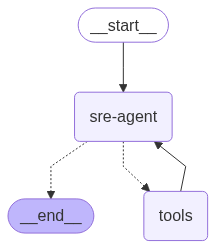

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sre-agent")
builder.add_conditional_edges(
    "sre-agent",
    # If the latest message (result) from sre-agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from sre-agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "sre-agent")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
print(react_graph.get_graph(xray=True).draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	sre-agent(sre-agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> sre-agent;
	sre-agent -.-> __end__;
	sre-agent -.-> tools;
	tools --> sre-agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [10]:
import time

async def test_async_graph(graph , human_message: str, trace_name: str = None):
    """Test the graph with proper async execution"""
    # Create a human message from the input
    messages = [HumanMessage(content=human_message)]
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke({"messages": messages}, config)

    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Print results
    for m in result['messages']:
        m.pretty_print()
    
    # Calculate token usage
    total_tokens = 0
    input_tokens = 0
    output_tokens = 0
    
    for m in result['messages']:
        if hasattr(m, 'usage_metadata'):
            if m.usage_metadata:
                if 'input_tokens' in m.usage_metadata:
                    input_tokens += m.usage_metadata['input_tokens']
                if 'output_tokens' in m.usage_metadata:
                    output_tokens += m.usage_metadata['output_tokens']
                if 'total_tokens' in m.usage_metadata:
                    total_tokens += m.usage_metadata['total_tokens']

    result["total_tokens"] = total_tokens
    result["input_tokens"] = input_tokens
    result["output_tokens"] = output_tokens
    result["execution_time"] = execution_time
    
    print(f"\nExecution time: {execution_time:.2f} seconds")
    print(f"Token usage: {total_tokens} total ({input_tokens} input, {output_tokens} output)")
    
    return result

In [11]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE ReAct agent"

In [12]:
human = ""

result_baseline = await test_async_graph(react_graph, human, trace_name=experiment_name)

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  ping (call_oOSO98wU7Zn1YiunEOnMr1NB)
 Call ID: call_oOSO98wU7Zn1YiunEOnMr1NB
  Args:
================================= Tool Message =================================
Name: ping

Error: ExceptionGroup('unhandled errors in a TaskGroup', [ExceptionGroup('unhandled errors in a TaskGroup', [1 validation error for CallToolResult
content
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing])])
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_ZoIOzQmqRmjmiyqZ3aoNnoWJ)
 Call ID: call_ZoIOzQmqRmjmiyqZ3aoNnoWJ
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
================================= Tool Message =

In [14]:
# Final AI response
result_baseline["messages"][-1].pretty_print()

================================== Ai Message ==================================

Summary — issue found
- The frontend fails to reach Consul during its startup: repeated "connection refused" errors to the Consul ClusterIP (10.96.1.251:8500). This is a startup race: frontend starts and immediately queries Consul before the Consul agent/http server is ready, producing many errors. Consul becomes ready ~9–10s later and then the frontend succeeds.

Evidence (key logs & resources)
- Frontend pod start and errors (frontend logs):
  - Frontend initialized and started at ~2025-09-02T06:51:27Z and immediately logs repeated errors like:
    - grpc/lb/consul: error retrieving instances from Consul: Get "http://consul:8500/v1/health/service/srv-search?passing=1": dial tcp 10.96.1.251:8500: connect: connection refused
  - Those connection-refused messages occur from 06:51:27 through 06:51:36+.
  - At 2025-09-02T06:51:37Z frontend logs "Successfull" and "Serving http" (i.e., it eventually completed 

In [13]:
import os
import datetime
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def saveExperiment(experiment_name, result):
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    results_folder = "results"
    os.makedirs(results_folder, exist_ok=True)

    # Create the full path for the file
    file_path = os.path.join(results_folder, f"{timestamp}.txt")

    # Format and write messages to file
    with open(file_path, 'w') as f:
        f.write(f"{'='*50}\nEXPERIMENT SUMMARY\n{'='*50}\n\n")
        if experiment_name:
            f.write(f"Experiment Name: {experiment_name}\n")
        f.write(f"Total tokens used: {result['total_tokens']}\n")
        f.write(f"Input tokens: {result['input_tokens']}\n")
        f.write(f"Output tokens: {result['output_tokens']}\n")
        f.write(f"Execution time: {result['execution_time']:.2f} seconds\n\n")

        f.write(f"{'='*50}\nSYSTEM PROMPT\n{'='*50}\n\n")
        f.write(sys_msg.content + "\n\n")
        

        for i, message in enumerate(result['messages']):
            f.write(f"{'='*50}\nMESSAGE {i+1}\n{'='*50}\n")
            
            if isinstance(message, HumanMessage):
                f.write(f"Type: Human Message\n")
                f.write(f"Content: {message.content}\n\n")
            
            elif isinstance(message, AIMessage):
                f.write(f"Type: AI Message\n")
                if message.content:
                    f.write(f"Content: {message.content}\n\n")
                
                if hasattr(message, 'additional_kwargs') and 'tool_calls' in message.additional_kwargs:
                    tool_calls = message.additional_kwargs['tool_calls']
                    f.write(f"Tool Calls ({len(tool_calls)}):\n")
                    
                    for idx, tool_call in enumerate(tool_calls):
                        f.write(f"  Tool Call {idx+1}: {tool_call['id']}\n")
                        if 'function' in tool_call:
                            f.write(f"    Function: {tool_call['function']['name']}\n")
                            f.write(f"    Arguments: {tool_call['function']['arguments']}\n\n")
            
            elif isinstance(message, ToolMessage):
                f.write(f"Type: Tool Response\n")
                f.write(f"Tool Call ID: {message.tool_call_id}\n")
                f.write(f"Content:\n{message.content}\n\n")
            
            else:
                f.write(f"Type: Other Message Type ({type(message).__name__})\n")
                f.write(f"Content: {str(message)}\n\n")

    print(f"Messages exported to {file_path}")

In [14]:
saveExperiment(experiment_name, result_baseline)

Messages exported to results/20250908_121213.txt


# Improve agent efficiency (in terms of tokens)

## Reduce context by passing only three messages

In [15]:
MAX_MESSAGES = 7

In [41]:
system_prompt_reduced_input = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    Important constraint:
    You only have access to the {max_messages} most recent messages in this conversation. 
    Anything older is not visible to you, so do not reference or assume context beyond those last {max_messages} messages.

    Your task:
        - Begin by analyzing the service's state and telemetry.
        - Then submit your solution: describe the issue you have identified and the root cause (without fixing it).
        - Also explain your reasoning and thought process.
        - Do not add any followup questions nor additional context.
"""

app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [17]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage

# System message
sys_msg_reduced = SystemMessage(content=system_prompt_reduced_input.format(app_summary=app_summary, max_messages=MAX_MESSAGES))

# Node which limits the context window 
async def sreAgent_reducedInput(state: MessagesState):

   messages = state["messages"]

   if len(state["messages"]) <= MAX_MESSAGES:
      return {"messages": [llm_with_tools.invoke([sys_msg_reduced] + messages)]}
   
   # Reduce the context window by taking only the last few messages
   context_messages = []

   # Work backwards from the end
   i = len(messages) - 1
   while i >= 0 and len(context_messages) < (MAX_MESSAGES + 2):
      msg = messages[i]
      context_messages.insert(0, msg)
      
      # If this is a ToolMessage, make sure to include the AIMessage that called it
      if isinstance(msg, ToolMessage) and i > 0:
         prev_msg = messages[i-1]
         if isinstance(prev_msg, AIMessage) and hasattr(prev_msg, 'additional_kwargs'):
               if 'tool_calls' in prev_msg.additional_kwargs and prev_msg not in context_messages:
                  context_messages.insert(0, prev_msg)
      i -= 1

      return {"messages": [llm_with_tools.invoke([sys_msg_reduced] + context_messages)]}




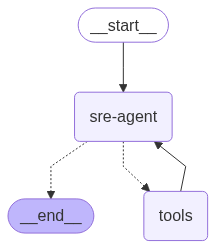

In [42]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("sre-agent", sreAgent_reducedInput)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "sre-agent")
builder.add_conditional_edges(
    "sre-agent",
    # If the latest message (result) from sre-agent is a tool call -> tools_condition routes to tools
    # If the latest message (result) from sre-agent is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "sre-agent")
react_graph_reduced = builder.compile()

# Show
display(Image(react_graph_reduced.get_graph(xray=True).draw_mermaid_png()))

In [43]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE ReAct agent"

In [46]:
human = ""

result_reduced = await test_async_graph(react_graph_reduced, human, trace_name=experiment_name)

================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_igHVxa3MDH55DDDmFyrdrRJs)
 Call ID: call_igHVxa3MDH55DDDmFyrdrRJs
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS       AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-qw2dt                                             0/1     Completed          0              88m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-66ffc                                   1/1     Running            0              96m   10.244.0.

In [47]:
# Final AI answer
result_reduced["messages"][-1].pretty_print()

================================== Ai Message ==================================

Analysis of service state and telemetry
- Source: logs from pod geo-6b4b89b5f5-d74mv (namespace test-hotel-reservation).
- Key log sequence (timestamps preserved):
  - "TLS disabled."
  - "Reading config..."
  - "Read database URL: mongodb-geo:27777"
  - "Initializing DB connection..."
  - ~11s later: "no reachable servers"
  - Immediately followed by panic stack trace (panic: no reachable servers) from main.initializeDatabase at cmd/geo/db.go:26, causing the process to exit.

Issue identified (concise)
- The geo service is failing to connect to its MongoDB backend (mongodb-geo:27777). The MongoDB driver reports "no reachable servers", and the application panics during database initialization, causing the geo pod to crash/exit.

Reasoning and thought process
1. Evidence in logs:
   - The application explicitly logs the DB URL it attempts to use: mongodb-geo:27777.
   - The next meaningful event is the Mon

In [48]:
saveExperiment(experiment_name, result_reduced)

Messages exported to results/20250908_122242.txt


## Use custom structured schema

This approach improves token efficiency by replacing the full message history with a structured summary. Instead of passing all previous messages to the LLM, the agent maintains:

- **`insights`**: Key findings from each investigation step
- **`prev_steps`**: Concise descriptions of actions taken
- **`response`**: Final diagnosis when investigation is complete

After each tool execution, a `summarise` node extracts the most important information and updates the structured state. This allows the agent to maintain context while significantly reducing token usage compared to the baseline approach.

In [23]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str
    final_output: str

In [24]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Begin by analyzing the service's state and telemetry using kubectl tools
        2. When you have identified the issue, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the issue you have identified (without fixing it)
            - reasoning: Explain your reasoning and thought process behind the solution

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [25]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. From the latest two messages, extract the most important new insight relevant for incident diagnosis or mitigation. Summarize it concisely.
    2. Write a concise description of only the most recent action taken including the tool used (not the whole list).  
"""

In [26]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [27]:
llm_with_strct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [28]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

In [29]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_strct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

In [30]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"Diagnosis:\n{diagnosis}\n\nReasoning:\n{reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
tools_with_completion = tools + [completion_tool]

In [31]:
async def sreAgent(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"]
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(tools_with_completion, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [32]:
async def format_response(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    message = "**Results of the analysis**\n\n"

    message += "Steps performed:\n"
    message += prev_step_str

    message += "\n\nInsights gathered:\n"
    message += insights_str

    message += "\n\nFinal report\n"

    message += state["response"]

    return {"final_output" : message}

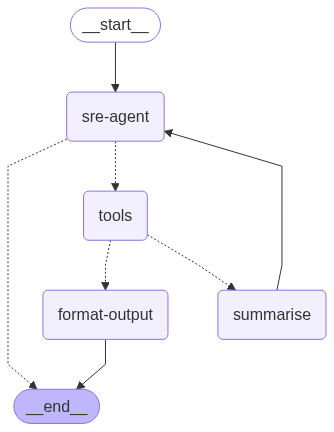

In [33]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools_with_completion)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("format-output", format_response)

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return "format-output"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "format-output": "format-output"
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")
builder.add_edge("format-output", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [34]:
print(structured_graph.get_graph(xray=True).draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	sre-agent(sre-agent)
	tools(tools)
	summarise(summarise)
	format-output(format-output)
	__end__([<p>__end__</p>]):::last
	__start__ --> sre-agent;
	sre-agent -.-> __end__;
	sre-agent -.-> tools;
	summarise --> sre-agent;
	tools -.-> format-output;
	tools -.-> summarise;
	format-output --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [35]:
import time

async def test_structured_graph(graph, app_summary:str, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "response": "",
        "final_output" : "",
        "app_summary" : app_summary
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    return result

In [36]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent"

In [37]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [38]:
human = ""
structured_result = await test_structured_graph(structured_graph, app_summary, human, experiment_name)

In [40]:
print(structured_result["final_output"])

**Results of the analysis**

Steps performed:

- Executed kubectl_get to list pods across all namespaces (equivalent to `kubectl get pods --all-namespaces`).
- Ran kubectl_get for pods in namespace test-hotel-reservation (kubectl get pods -o wide).
- Ran kubectl_describe on pod geo-6b4b89b5f5-d74mv in namespace test-hotel-reservation (kubectl describe pod).
- Fetched the previous pod logs using kubectl_logs for geo-6b4b89b5f5-d74mv in namespace test-hotel-reservation (tail=500, timestamps=true).
- Ran kubectl_get for services in namespace test-hotel-reservation (kubectl get services -o wide).

Insights gathered:

- kubectl get pods --all-namespaces shows cluster pods are healthy: nearly all pods are Running and one job is Succeeded. No Pending/CrashLoopBackOff/Error states observed (application pods in test-hotel-reservation are Running).
- The geo pod (geo-6b4b89b5f5-d74mv) in namespace test-hotel-reservation is in CrashLoopBackOff with 19 restarts while most other pods are Running — 

In [56]:
for step in structured_result["prev_steps"]:
    print(step)

Used kubectl_get to list all pods across all namespaces with wide output (kubectl get pods --all-namespaces -o wide).
Used kubectl_describe to describe pod 'geo' in namespace 'test-hotel-reservation' and inspect container state and events.
Called kubectl_logs to retrieve the last 500 lines from pod 'geo' (container 'hotel-reserv-geo') in namespace 'test-hotel-reservation'; the tool errored with "Resource pod geo not found".
Ran kubectl_get (kubectl get pods --all-namespaces -o wide) to list pods and discover the current geo pod instance.
Used kubectl_logs to fetch the last 500 lines from pod geo-6b4b89b5f5-qnznd (container hotel-reserv-geo).
Ran kubectl_get (kubectl get pods -n test-hotel-reservation -o wide) to list pod statuses and IPs.
Ran kubectl_get to list Services in namespace test-hotel-reservation (wide output).
Fetched logs using kubectl_logs for pod geo-6b4b89b5f5-qnznd (namespace test-hotel-reservation), container hotel-reserv-geo (tail 200).


In [57]:
for insight in structured_result["insights"]:
    print(insight)

The 'geo' pod in namespace 'test-hotel-reservation' is in Error (0/1) with 8 restarts (last restart ~5m29s ago), indicating a recurring crash that may be impacting the test-hotel-reservation service.
The container hotel-reserv-geo is in CrashLoopBackOff (RestartCount 8). Last termination was Error with Exit Code 2 and the process ran only ~11s before exiting — indicating the application binary crashes shortly after startup (image pulls succeeded).
Attempt to fetch logs for pod 'geo' failed: kubectl_logs returned "Resource pod geo not found" — the pod instance is missing/was removed or renamed, so the previous CrashLoopBackOff pod logs are not available from that pod identity.
The geo pod is present as geo-6b4b89b5f5-qnznd in namespace test-hotel-reservation and is in CrashLoopBackOff with RestartCount 8 (last restart ~46s ago) — confirming a recurring crash and giving the current pod name to target for logs/debugging.
The geo service (container hotel-reserv-geo) panics on startup with 

In [58]:
print(structured_result["response"])

Diagnosis:
The geo service is crashing on startup because it's configured to connect to MongoDB at mongodb-geo:27777, but the mongodb-geo Service exposes port 27017. This port mismatch prevents the geo app from reaching the database (logs show "no reachable servers"), causing a panic during initializeDatabase and putting the pod into CrashLoopBackOff.

Reasoning:
Investigation steps and evidence:

- Listed pods across all namespaces and inspected the test-hotel-reservation namespace. The geo pod (geo-6b4b89b5f5-qnznd) is in CrashLoopBackOff with RestartCount 8 and recent restarts; container exited quickly (last run ~11s) with Exit Code 2, indicating the process crashes shortly after startup.

- Attempted to fetch logs from an earlier pod identity failed because the pod name had changed; retrieved logs from the current geo pod (hotel-reserv-geo container).

- Logs from the geo container show it reads a DB URL of "mongodb-geo:27777", attempts to initialize the DB, and then panics with "n

In [59]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_kYbRnJ8BC5bHzv97f1GVGW8u)
 Call ID: call_kYbRnJ8BC5bHzv97f1GVGW8u
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS      RESTARTS        AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-64xds                                             0/1     Completed   0               17m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-dqndb                                   1/1     Running     0               21m   10.244.0.3    kind-control-plane   <none>           <none>
kube-system              coredns-668d6bf9bc-hxz6t  